In [140]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Perceptron as Perc

# <center>The Perceptron strikes back</center>
<center><img src=https://thumbs.gfycat.com/ScalyOpenHydatidtapeworm-max-1mb.gif></center>

During this lab we will extend what we have learnt about classification before. We we will use the skills obtained by building our own perceptron. 

#### a) Come back to the last lab task and recall information about the basic perceptron algorithm. Specifically:
- what is the form of the input vector?
- what is the body of the perceptron?
- what is the `activation function` and what it does?
- what is the bias?

Take the Perceptron class quickly implemented below (or the one made on your own) and make sure that you understand what all the methods do.

In [141]:
class Perceptron:
    # Initialize the bias and the dimension of the perceptron. 
    def __init__(self, W : np.array,  b = 0):
        self.W = W
        self.N = len(W)
        self.b = b
    
    ############################## GETTERS ##############################
    
    def get_N(self):
        return self.N
    
    def get_b(self):
        return self.b
    
    def get_W(self):
        return self.W
    
    ############################## SETTERS ##############################
    
    # Create setters for the perceptron
    def set_N(self, N):
        self.N = N
        self.W = np.zeros(N)
        
    def set_b(self, b):
        self.b = b
        
    def set_W(self, W : np.array):
        if W.ndim != 1:
            print("Cannot set such weights -> dimension wrong")
            return
        self.N = W.shape[0]
        self.W = W
    
    ############################## GETTERS OVERRIDE ##############################
    
    def __getitem__(self, key):
        return self.W[key]
    
    def __setitem__(self, key, value):
        self.W[key] = value
        
    def __getslice(self, i, j):
        return self.W[i:j]
    
    # set the string output of the perceptron 
    def __str__(self):
        return f"Am a perceptron of N={self.N} dimension{'s' if self.N > 1 else ''} biased with b={self.b}"    

    ############################## OPERATORS OVERRIDE ##############################
     
    def __mul__(self, other):
        return self.activation_function(other)
    
    def __rmul__(self, other):
        return self.__mul__(other)

    ############################## PERCEPTRON METHODS ##############################
    
    '''
    Net output is the basic body action of the perceptron. On top of it, the activation function is used.
    '''
    def net_output(self, X):
        return np.dot(X, self.W) + self.b
    
    '''
    Here the activation function is step-like
    '''
    def activation_function(self, X):
        return np.where(self.net_output(X) >= 0.0, 1.0, 0.0).reshape((len(X),1))
   
    '''
    Predicts the output of perceptron -> here the class is given   
    '''
    def predict(self, X):
        return self.activation_function(X)
        

Look at the extended version of the Perceptron below. What changes are made to it?
Please note that gradient descent can be calculated in batches (in case of linear regression):
$$w_j\leftarrow w_j + \eta \sum_{i=0}^{n_{batch}} \delta _i x_j^{(i)}$$

The batch size is a `hyperparameter` that defines the number of samples to work through before updating the internal model parameters. Normally batches are randomly selected and this allows to speed up the learning curve without missing the main result of the optimization problem. Nevertheless, one must note that batches cannot be too big (or sometimes even too small), especially when we have only few samples of one class compared to the other ones - unbalanced databases. 

There are three main ways to define batches, namely:
-    Batch Gradient Descent. Batch Size = Size of Training Set
-    Stochastic Gradient Descent. Batch Size = 1
-    Mini-Batch Gradient Descent. 1 < Batch Size < Size of Training Set

Then we can state that `the batch size is a number of samples processed before the model is updated`.

In [142]:
class PerceptronLinear(Perceptron):
    # Initialize the bias and the dimension of the perceptron -> but not only that
    def __init__(self, W : np.array,  b = 0, epo = 100, lr = 0.01):
        super().__init__(W, b)
        # how many learning iterations we give
        self.epo = epo
        # what is our step in the gradient
        self.lr = lr
    
    ############################## GETTERS ##############################

    def get_lr(self):
        return self.lr

    def get_epo(self):
        return self.epo
    
    ############################## SETTERS ##############################
    
    def set_lr(self, lr):
        self.lr = lr
        
    def set_epo(self, epo):
        self.epo = epo

    ############################## PERCEPTRON METHODS ##############################
    '''
    As you can see the activation function has been changed to linear regression. What does reshape do?
    After you figure it out, note that it is the usual way of having the output of the machine learning algorithm. Why?
    '''
    def activation_function(self, X):
        return (self.net_output(X)).reshape(-1,1)
    
    '''
    Loss function for the perceptron -> here we use the Mean Square Error
    '''           
    def loss(self, y_true : np.array, y_pred : np.array):
        square = np.square(y_true - y_pred)
        return np.mean(square)
    
    '''
    Single step of the gradient (but for an entire batch), which is here calculated analytically (linear regression)
    '''
    def gradient(self, x_true, y_true, prediction):
        delta_i = (y_true.flatten() - prediction.flatten())
        suma_w = np.multiply(delta_i[:, np.newaxis], x_true) # (here we use element-wise multiplication)
        suma_b = delta_i # suma_b is for updating the bias; it assumes that x_j=1
        return suma_b, suma_w
    
    '''
    Fit function allows to obtain the (probably most?) correct weights for the perceptron via the gradient descent algorithm.
    '''
    def fit(self, X, y, randomstate = None, batch = 1, verbose = False):
        
        if type(X) != np.ndarray:
            X = np.array(X)
        if type(y) != np.ndarray:
            y = np.array(y).reshape(-1,1)
            
        # whenever the parameter randomstate is not None, the weights
        # are reset to be random normal - this ensures random starting point of gradient descent
        if randomstate is not None:
            self.W = np.random.normal(0.0, 0.1, self.N)
            self.b = np.random.normal(0.0, 1.0)
        
        # Save the history of the losses. Why?
        history = []
        # If we want to calculate the gradient in buckets (look for description of the batch)
        bucket_num = len(X) // batch # // is floor division
        # slice the data into batches without shuffling (no stochasticity)
        slicing = lambda x, b: x[(b-1)*batch:b*batch]
        
        # iterate over epochs
        for epo in range(self.epo):
            # iterate over batches
            loss = 0.0
            for bin in range(1, bucket_num + 1):
                X_slice = slicing(X,bin)
                y_slice = slicing(y,bin)
                # predict the output for a given slice (what is the shape of the output?)
                pred = self.predict(X_slice)
                
                suma_b, suma_w = self.gradient(X_slice, y_slice, pred)

                # calculate loss
                loss += self.loss(y_slice, pred.flatten())
                
                # update the weights and bias
                self.W += np.mean(suma_w, axis = 0) * self.lr
                self.b += np.mean(suma_b, axis = 0) * self.lr 
            # calculate average loss
            loss/=bucket_num
            if verbose:
                print(f'epo:{epo}->loss={loss}')        
            history.append(loss.flatten())
        return np.array(history).flatten()
    '''
    Basic history plot
    '''        
    def plot_history(self, history, ax = None):
        if ax is None:
            fig, ax = plt.subplots()
        ax.set_xlabel('epo')
        ax.set_ylabel('loss')
        ax.plot(history)
    
    

#### b) Test the linear Perceptron on linearized data with normal noise.

In [143]:
X = np.arange(0, 100, 1)
y = 3 * X + 5 + np.random.normal(0, 1e1, size = len(X))

X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

# Split the data by hand or using train_test_split(), but DO NOT SHUFFLE if you use the latter. This is because we want to have a nice plot later.
X_train = 
y_train = 
X_test = 
y_test = 

In [144]:
lin_reg = 

history = lin_reg.fit(X=X_train, y=y_train, randomstate=, batch=)
lin_reg.plot_history(history)

In [145]:
plt.scatter(X_train, y_train, color="blue", s=10, label="train_data")
plt.scatter(X_test, y_test, color="green", s=10, label="test_data");
plt.scatter(X_test, lin_reg.activation_function(X_test).reshape(-1, 1), color="red", s=10, label="pred_data")
plt.legend()

#### c) Taking the inspiration from the work above work out the procedure to create a Perceptron that is able to learn basic classification. 
Recall the information from the lecture. Use the MSE loss function, which for binary classification is of much simpler form. Use the loss function that has been calculated analytically for binary labels $\{-1,1\}$:
$$\vec{W} \leftarrow \vec{W} + \eta \sum_i y_i (1-y_i \hat{y}_i)\vec{X_i}.$$
The sum arises in the batch update.

In [118]:
class PerceptronBinary(PerceptronLinear):
    def __init__(self, W : np.array,  b = 0, epo = 100, lr = 0.01):
        super().__init__(W, b, epo, lr)
        
    '''
    $\Phi(x) = sign(x)
    '''
    def activation_function(self, X):

    
    '''
    Loss function for the perceptron -> here we use knowledge that the classes can be either {-1, 1}
    '''           
    def loss(self, y_true : np.array, y_pred : np.array):

    
    '''
    Single step of the gradient, here it is calculatable analytically (linear regression). 
    It shall return a numpy array for bias and for weights (which will be later summed, hence the name sum), where the elements correspond to different samples in one batch.
    Remember that it should work also for batch updates.
    '''
    def gradient(self, x_true, y_true, prediction):
        
        suma_w = 
        suma_b =       
        return suma_b, suma_w

##### Recall this:

"

Set the appropriate weights for the perceptron to reproduce this table:

\begin{array}{|c|c|c|c|}
    \text{Training example} & x_1 & x_2 & \text{Classification} \\
    A&0&1&-1\\
    B&2&0&-1\\
    C&1&1&1\\
    D&2&3&1
\end{array}

"

#### d) Use the Perceptron above to check, whether you were right about the weights during the previous lab!

In [119]:
a = PerceptronBinary(np.random.random(2), np.random.random(), 100, 1e-1)
x_train = [[0.,1.], [2.,0.], [1.,1.], [2.,3.]]
y_train = [-1., -1., 1.,1.]
for d in x_train:
    plt.scatter(d[0],d[1])
plt.legend(y_train)

In [120]:
history = a.fit()
a.plot_history(history)
a.predict(x_train), a.get_W()

What happens when the data is not linearly seperable?

In [121]:
# Some helper functions useful below
'''
Given a vector find a (random) vector orthogonal to it
'''
def find_orthogonal_vector(x):
    x_p = np.random.random(len(x))
    x_p -= x_p.dot(x) * x / np.linalg.norm(x)**2.0
    return x_p

'''
Find vector from two points
'''
def find_plane_from_ort(perp1, perp2):
    # a * x1 + b = y1
    # a * x2 + b = y2
    # -> a * (x1-x2) = (y1-y2) -> a = (y1-y2)/(x1-x2)
    a = (perp1[1] - perp2[1])/(perp1[0]-perp2[0])
    b = perp1[1] - a * perp1[0] 
    return a,b

#### e) Take 50 randomly initialized points in 2D -> $r=[x=rand(), y=rand()]$ such that $x,y \in [-1,1]$. 
For each of them assign a class such that:

\begin{equation}
\hat{y} = 
\left \{
   \begin{array}{lr}
       1 & y \geq 3 * x - 1 \\
       -1 &\text{otherwise}
   \end{array}
\right .
\end{equation}

Randomly initialize vector $\vec{W}$ of the perceptron. It is the normal vector of the hyperplane $\vec{W}\cdot \vec{X}=0$ which separates the data into two classes.

Train the perceptron to fit the data. Use 50 epochs. At each 10th epoch plot the vector perpendicular to $\vec{W}$ Use the functions above to find the perpendicular vector and plane (line) in 2D. What can we tell about the learning algorithm?

Here, the idea is to recreate slide 34 from `perceptron_algorithm.pdf` lecture.



In [122]:
fig, ax = plt.subplots(2, figsize = (5,5))
x_train = 2.0*np.random.random((50, 2)) - 1.0 # array of (x,y) coordinates; look out the 'x' in x_train is a different x than in (x,y). The same for y. Sorry for that.
y_train = 

# set the x_range to plot the real line:
x=np.arange(-1, 1, 1e-2)

# set the classes for the plot
colors = ['red' if y > 0 else 'blue' for y in y_train]
labels = ['1' if y > 0 else '-1' for y in y_train]

ax[0].plot(x, 3*x-1, linestyle=':', label = 'true')
ax[0].scatter(x_train[:,0], x_train[:,1], c = colors)
ax[0].set_xlim(-1,1)
ax[0].set_ylim(-1,1)

# set the initial vector W to be two-dimensional random
W = 
# find two orthogonal vectors and then the hyperplane corresponding to them
perp1 = 
perp2 = 
plane = 

p=PerceptronBinary(W, np.random.random(), epoch=1, lr=1e-3)

epo = 101
# take the snapshot at each 50th step
modulo = 50
history=[]
for i in range(epo): 
    if i % modulo == 0:
        perp1 = 
        perp2 = 
        plane = 
        ax[0].scatter(x, plane[0] * x + plane[1], label = i, s=2)
        ax[0].plot([0.0, W[0]],[0.0,W[1]],c='black')
        
    history = history + list(p.fit(x_train, y_train))
    W = p.get_W()
    
ax[0].legend()
p.plot_history(history, ax[1])
(p.predict(x_train).flatten()- y_train) != 0.0

##### [DISCLAIMER] Note that the plot of the decision bound is in fact here just conceptual as $W_0=b$ is also sought with the gradient descent and is not used for the plot. 

We can see that the perceptron is a basic concept that can be treated as a linear separation classifier. The linearization depends though on the way the data is treated. This means that changing the activation function can change the way Perceptron is classifying things either by linear regression or plane separation. Therefore, vector perpendicular to the Perceptron body weights gives us a linear decision boundary in a given dimension:

$$ \vec{X} \cdot \vec{W} = 0.$$

In binary classification then we can be clever and consolidate the output into just one equation:

$$ -y^i \vec{X^i}\cdot \vec{W} < 0.$$

We can introduce the idea of another function commonly used in Machine Learning, inputing in into the cost function. Namely, one can use the function:

$$ g_i(\vec{W}) = \max{(0, -y^i \vec{X^i}\cdot \vec{W})}. $$ 

If the result is classified correctly, the function is always nonnegative. (SHOW WHY?)

Such a cost function is known as [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) (rectified linear unit). 

In [123]:
x=np.arange(-1, 1, 1e-2)
plt.plot(x, x*(x>0))
plt.title('ReLU')
plt.xlabel('x')
plt.ylabel('$\max{(0,x)}$')

In that case the total cost function can be written as:
$$ L = \frac{1}{N}\sum _i g_i(\vec{W}).$$
Sometimes such a cost function is called a hinge loss. It is always convex (why is it important?) but we cannot use a Newton's method for it as it is not continoius at $x=0$! 

##### [TIP] Sometimes to fix the gradient in a function one uses smothened versions of ReLU with different parameters to smoothen them. Their usage is discussed broadly in Machine Learning community.

##### [DISCLAIMER] Keep in mind that here ReLU is used as a loss function but mostly it is discused in terms of being the activation function. Nevertheless, it turns out that for a single perceptron it means the same. 

One of the examples that can be used instead is a function called Softmax:

$$ g(x) = soft(0, x) = \log(1+e^x)\rightarrow g_i(\vec{W}) = soft(0, -y^i\vec{X}^i\cdot \vec{W})$$

#### f) Calculate the gradient $\frac{\partial}{\partial W_k}$ of the newly created loss function with the softmax activation.
$$ L_i = \log(1+e^{ -y^i\vec{X}^i\cdot \vec{W}}). $$
Change perceptron and use it for classification of the random data again. Which loss function performs better? Try using batches.

In [124]:
class PerceptronSoftmax(PerceptronLinear):
    def __init__(self, W : np.array,  b = 0, epo = 100, lr = 0.01):
        super().__init__(W, b, epo, lr)
        
    '''
    $\Phi(x) = sign(x)
    '''
    def activation_function(self, X):
        return np.where(self.net_output(X) >= 0.0, 1.0, -1.0).reshape(-1,1)
    
         
    def loss(self, y_true : np.array, y_pred : np.array):
        return np.log(1+np.exp(-y_true * y_pred))
        
    '''
    Single step of the gradient, here it is calculatable analytically (linear regression)
    '''
    def gradient(self, x_true, y_true, prediction):
        val = np.multiply(y_true, (1.0/(1.0 + np.exp(y_true * prediction))))
        suma_w = np.multiply(val[:, np.newaxis], x_true)
        suma_b = val         
        return suma_b, suma_w

Test it by doing the same plot as before! TIP: vary learning rate.

array([False, False, False,  True, False, False, False, False, False,
        True, False, False, False,  True, False, False, False, False,
       False,  True, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False])

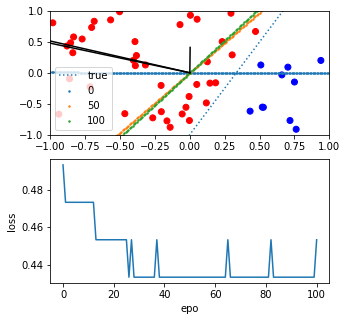

In [131]:
fig, ax = plt.subplots(2, figsize = (5,5))
x_train = 2.0*np.random.random((50, 2)) - 1.0 # array of (x,y) coordinates; look out the 'x' in x_train is a different x than in (x,y). The same for y. Sorry for that.
y_train = np.array([1 if y >= 3*x - 1 else -1 for (x,y) in x_train])

# set the x_range to plot the real line:
x=np.arange(-1, 1, 1e-2)

# set the classes for the plot
colors = ['red' if y > 0 else 'blue' for y in y_train]
labels = ['1' if y > 0 else '-1' for y in y_train]
ax[0].plot(x, 3*x-1, linestyle=':', label = 'true')
ax[0].scatter(x_train[:,0], x_train[:,1], c = colors)
ax[0].set_xlim(-1,1)
ax[0].set_ylim(-1,1)

# set the initial vector W to be two-dimensional random
W = np.random.random(2)
# find two orthogonal vectors and then the hyperplane corresponding to them
perp1 = find_orthogonal_vector(W)
perp2 = find_orthogonal_vector(W)
plane = find_plane_from_ort(perp1, perp2)

p=PerceptronSoftmax(W, np.random.random(), 1, 1e-2)

epo = 101
# take the snapshot at each 50th step
modulo = 50
history=[]
for i in range(epo): 
    if i % modulo == 0:
        perp1 = find_orthogonal_vector(W)
        perp2 = find_orthogonal_vector(W)
        plane = find_plane_from_ort(perp1, perp2)
        ax[0].scatter(x, plane[0] * x + plane[1], label = i, s=2)
        ax[0].plot([0.0, W[0]],[0.0,W[1]],c='black')
        
    history = history + list(p.fit(x_train, y_train))
    W = p.get_W()
    
ax[0].legend()
p.plot_history(history, ax[1])
(p.predict(x_train).flatten()- y_train) != 0.0



### Newton's method. 
For smaller datasets it is sometimes usefull to use the Newton's method to find the function minumum with faster convergence. Suppose we have some function:
$$ f : \mathbb{R} \rightarrow \mathbb{R} .$$

We try to find a value where f(x) = 0 (or as close as possible). For this we set some initial point $x_0$ and calculate $f(x_0)$. If $x_0$ is near some real point close to 0 - $\alpha$, then the tangent line at $x_0$ crosses the x-axis closer and closer to $\alpha$. 

<center><img src=https://upload.wikimedia.org/wikipedia/commons/e/e0/NewtonIteration_Ani.gif></center>


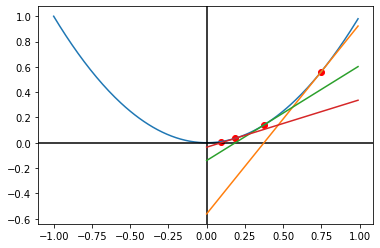

In [132]:
def find_a_and_b_and0(prev_x, prev_y, diff):
    # y_0 = a_0 * x_0 + b_0 -> b_0 = y_0 - a_0*x_0
    a = diff(prev_x)
    b = prev_y - a * prev_x 
    zero = - b / a
    return a, b, zero

x=np.arange(-1,1,1e-2)
f = lambda x : np.square(x)
df = lambda x : 2 * x

plt.plot(x, f(x))
plt.axvline(0.0, c='black')
plt.axhline(0.0, c='black')

x_0 = 0.75
y_0 = f(x_0)
plt.scatter(x_0, y_0, c='red')

# find first tangent line
a_0, b_0, x_1 = find_a_and_b_and0(x_0, y_0, df)
y_1 = f(x_1)
plt.plot(x[len(x)//2:], a_0 * x[len(x)//2:] + b_0)
plt.scatter(x_1, y_1, c='red')

# find second tangent line
a_1, b_1, x_2 = find_a_and_b_and0(x_1, y_1, df)
y_2 = f(x_2)
plt.plot(x[len(x)//2:], a_1 * x[len(x)//2:] + b_1)
plt.scatter(x_2, y_2, c='red')

# find third tangent line
a_2, b_2, x_3 = find_a_and_b_and0(x_2, y_2, df)
y_3 = f(x_3)
plt.plot(x[len(x)//2:], a_2 * x[len(x)//2:] + b_2)
plt.scatter(x_3, y_3, c='red')

# etc...

The extrema of the loss function correspon to points where its first derivative is zero so we need to use the same algorithm by simply calculating the second derviatives of the function. If $\vec{W}$ is the vector of weights, we need to generalize it to multidimensional system and use [Newton-Raphson](https://en.wikipedia.org/wiki/Newton%27s_method) method.

$$ \vec{W} \leftarrow W - H^{-1} \nabla _{\vec{W}} \vec{L}(\vec{W}),$$

where $\nabla _{\vec{W}} \vec{L}(\vec{W})$ is the vector of partial derivatives of the cost function with respect to $W$ and $H$ os a $n\times n$ matrix ($n+1 \times n+1$) with bias called the Hessian such that:

$$ H_{ij} = \frac{\partial ^2 L(\vec{W})}{\partial w_i \partial w_j}.$$

Newton’s method typically enjoys faster convergence than (batch) gradient descent and requires many fewer iterations to get very close to the maximum. One iteration of Newton’s can, however, be more expensive than one iteration of gradient descent, since it requires finding and inverting a d × d Hessian; but so long as d is not too large, it is usually much faster overall. Application of Newton’s method to maximize the logistic regression log likelihood function is also called Fisher scoring.

#### e) Add the method to calculate Newton-Raphson algorithm in the previous Perceptron. In order to do this, calculate the derviative:

$$ H_{ij} = \frac{\partial ^2 }{\partial w_i \partial w_j} \log(1+e^{ -y^i\vec{X}^i\cdot \vec{W}}).$$

In [134]:
class PerceptronSoftmax(PerceptronLinear):
    def __init__(self, W : np.array,  b = 0, epo = 100, lr = 0.01):
        super().__init__(W, b, epo, lr)
        
    '''
    $\Phi(x) = sign(x)
    '''
    def activation_function(self, X):
        # you can copy from above

    
         
    def loss(self, y_true : np.array, y_pred : np.array):
        # you can copy from above

        
    '''
    Single step of the gradient, here it is calculatable analytically (linear regression)
    '''
    def gradient(self, x_true, y_true, prediction):
        # you can copy from above

    
    def hessian(self, x_true, y_true, y_pred):

    
    def newton_rap(self, X, y, randomstate = None, verbose = False):        
        if type(X) != np.ndarray:
            X = np.array(X)
        if type(y) != np.ndarray:
            y = np.array(y).reshape(-1,1)
            
        # give fit the parameter randomstate and whenever it is not None, the weights
        # are reset to be random normal - this ensures random starting point of gradient descent
        if randomstate is not None:
            self.W = np.random.normal(0.0, 0.1, self.N)
            self.b = np.random.normal(0.0, 1.0)
        
        # Save the history of the losses. Why?
        history = []

        # iterate epochs
        # !!! START FILLING IN HERE


IndentationError: expected an indented block (2758024511.py, line 12)

#### h) Use the following data to test the algorithm for Newton-Rhapson
Use 5 epochs and $\vec{W} = [1],b=1$ as a starting point.

In [ ]:
X = np.array([-0.3, -0.1, 0.3, 0.5, 1.0, 1.3, 4.5, 3.5]).reshape(-1,1)
Y = np.array([-1,-1,-1, -1, 1,1,1,1],dtype=np.float64).reshape(-1,1)
plt.plot(X,Y)
plt.scatter(X,Y,c='red')
plt.xlabel('x')
plt.ylabel('class')

In [ ]:
p=PerceptronSoftmax(
history=p.newton_rap(X, Y)
p.plot_history(history)
p.predict(X)

#### i) Do the same for vector $\vec{W}=[4.0], b=-10$.

In [ ]:
p=PerceptronSoftmax(np.array([4.]),-10., epo = 100)
history=p.newton_rap(
p.plot_history(history)
p.predict(X.reshape(-1,1))

#### j) Look at an example below and analyse it. What happens with the weights?

In [ ]:
losses=[]
bs = np.arange(-10, 10, 0.5)
ws = np.arange(-10, 10, 0.5)
for b in bs:
    for w in ws:
        p=PerceptronSoftmax(np.array([w]),b)
        pred = p.predict(X)
        loss=p.loss(Y, pred)
        losses.append(np.mean(loss))
        
p=PerceptronSoftmax(np.array([1.0]),-1, 1, lr=1e-3)

size = len(ws)
c=plt.imshow(np.array(losses).reshape((size,size)))
plt.colorbar(c)

bs = []
ws = []
for i in range(1000):
    p.newton_rap(X, Y)
    b=p.get_b()
    w=p.get_W()[0]
    bs.append(b + size/2)
    ws.append(w + size/2)
    
plt.plot(ws, bs , c = 'red')

What we can observe from here is that the minimum of the function is constant for the weights going to infinity! How can we prevent such situation? ---> One can prevent this by using small learning rate or batches with the early stopping. 

##### [DISCLAIMER] Early stopping is a method that tracks the history of the loss function and twhen change after small number of eochs is lower than some threshold, or is netagtive for longer period, the learning procedure is stopped.


Another approach is to control the magnitude of the weights via `REGULARIZATION`. Normally we add some kind of norm to the loss function that we need to minimize. Usually, we take the length of the vector or a second order norm $||W|| or ||W||_2$, which are called $L_1$ and $L_2$ regularizations accordingly. Then, our loss function reassembles the behavior of Lagrange multipliers and looks like:

$$ L'= L+\lambda||W||_2,$$

where $\lambda$ is a small regularization parameter.
##### [DISCLAIMER] Using regularization is also useful for phenomena called [OVERFITTING](https://en.wikipedia.org/wiki/Overfitting).

#### k) Implement the regularization to the method. Use the loss that is suitable for you. You have to calculate the gradient of the newly created loss function.  

# Logistic regression

Logistic regression is yet another method of classification, which in principle can be accorded to a most common ML algorithms - the classification. It can be used for problems like spam classifiers, baseline primary classifiers, disease recognition etc. There are many multi-class versions of logistic regression. 

It basically uses the same tools as our Perceptron but changes the way activation function and loss is treated. `Recall the information about the logistic regression from the lecture`.

Logistic regression uses [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) activation function:

$$ p(\vec{W}, \vec{X}) = \frac{1}{1 + e^{-W\cdot X}}$$

It is used as an estimator of probability that a given class belongs to some label via maximizing the likelyhood instead of minimizing the distance. The probability equation that wew want to maximize is given by:
$$P(\vec{y}|\vec{W};\vec{X})= \sum _ i  p^{y^{i}}(1-p)^{1-y^{i}}$$

Then, it is easier to apply the sum of logarithms of such probabilities, therefore, after manipulations (from the lecture though), what we obtain is:
$$ L = -\sum _i [y^i\log p_i + (1-y^i)\log(1-p_i)]$$
where minus has been taken because maximizing likelyhood now coresponds to minimizing the loss and the gradient is easily obtained:
$$L = [y-\sigma (W\cdot X)]X, $$
where $\sigma (x) $ is the sigmoid function. Then we follow exactly the same procedure as before to train the network.

#### k) Create the logistic regression algorithm using the information from above. Implement Newton-Rhapson for it as well. 

#### l) Use LogisticRegression from sklearn and predict the linearly and nonlinearly separable data in 1D, just as before. Compare your model to the model used here. 

#### For the throughout guide of sklearn Logistic Regression one can follow this [website](https://realpython.com/logistic-regression-python/).

In [ ]:
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

<center><img src=https://cdn.vox-cdn.com/uploads/chorus_asset/file/13468746/giphy.gif></center>

#### m) Use the inbuilt Logistic Regressor from sklearn to test the classsification of handwritten digits database from sklearn. 